In [3]:
import pandas as pd
import numpy as np

np.float_ = np.float64

from prophet import Prophet
import requests
from datetime import datetime, timedelta
import duckdb as db

m = Prophet()
conn = db.connect("file.db")
conn.sql("""
    -- y is the amount charged for the transaction
    -- ds is the time the transaction took place

    -- CREATE SEQUENCE seq_id START 1;
    CREATE TABLE crypto_transfer (y DECIMAL, ds DATETIME UNIQUE)
""")

CatalogException: Catalog Error: Table with name "crypto_transfer" already exists!

In [12]:
rows = conn.sql("SELECT COUNT(*) FROM crypto_transfer").fetchall()
print(rows[0][0])

0


In [2]:
# Get data

end_time = datetime.now()
print(end_time.timestamp())
start_time = (end_time - timedelta(seconds=3600.0)).timestamp()
print(start_time)

transaction_types = ["CONTRACTCALL", "CRYPTOTRANSFER"]

from typing import Union
from pprint import pprint

def get_data(start_time: float | int, limit: int, transaction_type: str, order: Union["asc", "desc"]):
    url = f"https://testnet.mirrornode.hedera.com/api/v1/transactions?limit={limit}&order={order}&timestamp=gte%3A{start_time}&transactiontype={transaction_type}"
    data = requests.get(url).json()
    transactions = data["transactions"]
    new_transactions: list[dict | None] = []
    for transaction in transactions:
        new_data = {}
        if not transaction["scheduled"] and transaction["result"] == "SUCCESS":
            _, seconds, nanoseconds = transaction["transaction_id"].split("-")
            new_data["charged_tx_fee"] = round(transaction["charged_tx_fee"] / 1000000, 4)
            new_data["time_tx_occured"] = datetime.fromtimestamp(float(f"{seconds}.{nanoseconds}")).isoformat()

            new_transactions.append(new_data)
    return new_transactions


transactions: list[dict | None] = get_data(start_time, 100, transaction_types[1], "asc")
pprint(transactions)

1724005188.192686
1724001588.192686
[{'charged_tx_fee': 0.1853, 'time_tx_occured': '2024-08-18T17:19:50.753000'},
 {'charged_tx_fee': 0.1866, 'time_tx_occured': '2024-08-18T17:20:24.936000'},
 {'charged_tx_fee': 0.1866, 'time_tx_occured': '2024-08-18T17:20:24.993000'},
 {'charged_tx_fee': 0.1866, 'time_tx_occured': '2024-08-18T17:20:24.901000'},
 {'charged_tx_fee': 0.1866, 'time_tx_occured': '2024-08-18T17:20:25.305000'},
 {'charged_tx_fee': 0.1866, 'time_tx_occured': '2024-08-18T17:20:25.180000'},
 {'charged_tx_fee': 0.1853, 'time_tx_occured': '2024-08-18T17:20:26.741000'},
 {'charged_tx_fee': 0.1866, 'time_tx_occured': '2024-08-18T17:20:26.838000'},
 {'charged_tx_fee': 0.1853, 'time_tx_occured': '2024-08-18T17:20:27.585000'},
 {'charged_tx_fee': 0.1853, 'time_tx_occured': '2024-08-18T17:20:27.791000'},
 {'charged_tx_fee': 0.1853, 'time_tx_occured': '2024-08-18T17:20:28.003000'},
 {'charged_tx_fee': 0.1853, 'time_tx_occured': '2024-08-18T17:20:27.855000'},
 {'charged_tx_fee': 0.1866, 

In [3]:
try:
    for transaction in transactions:
        conn.sql(f"""
            INSERT INTO crypto_transfer VALUES ('{transaction["charged_tx_fee"]}', '{transaction["time_tx_occured"]}')
        """)
except db.ConstraintException:
    pass

In [4]:
conn.sql("""
    SELECT * FROM crypto_transfer
""").show()

┌───────────────┬─────────────────────────┐
│       y       │           ds            │
│ decimal(18,3) │        timestamp        │
├───────────────┼─────────────────────────┤
│         0.185 │ 2024-08-18 17:19:50.753 │
│         0.187 │ 2024-08-18 17:20:24.936 │
│         0.187 │ 2024-08-18 17:20:24.993 │
│         0.187 │ 2024-08-18 17:20:24.901 │
│         0.187 │ 2024-08-18 17:20:25.305 │
│         0.187 │ 2024-08-18 17:20:25.18  │
│         0.185 │ 2024-08-18 17:20:26.741 │
│         0.187 │ 2024-08-18 17:20:26.838 │
│         0.185 │ 2024-08-18 17:20:27.585 │
│         0.185 │ 2024-08-18 17:20:27.791 │
│           ·   │            ·            │
│           ·   │            ·            │
│           ·   │            ·            │
│         0.185 │ 2024-08-18 17:24:50.096 │
│         0.185 │ 2024-08-18 17:24:50.13  │
│         0.185 │ 2024-08-18 17:24:51.683 │
│         0.187 │ 2024-08-18 17:24:51.736 │
│         0.185 │ 2024-08-18 17:24:53.796 │
│         0.187 │ 2024-08-18 17:

In [5]:
df = conn.sql("""
    SELECT ds, y FROM crypto_transfer
""").to_df()
df.tail()

,ds,y
94,2024-08-18 17:24:53.827,0.187
95,2024-08-18 17:24:55.872,0.185
96,2024-08-18 17:24:55.936,0.187
97,2024-08-18 17:24:58.139,0.185
98,2024-08-18 17:24:50.362,0.185


In [6]:
m.fit(df)
future = m.make_future_dataframe(periods=30)

18:20:10 - cmdstanpy - INFO - Chain [1] start processing
18:20:10 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
124,2024-09-13 17:24:58.139,-5.778414,-5.794777,-5.761129,-5.778849,-5.777955,0.0,0.0,0.0,0.0,0.0,0.0,-5.778414
125,2024-09-14 17:24:58.139,-6.007847,-6.023249,-5.992154,-6.008302,-6.007364,0.0,0.0,0.0,0.0,0.0,0.0,-6.007847
126,2024-09-15 17:24:58.139,-6.237279,-6.252143,-6.222044,-6.237761,-6.236770,0.0,0.0,0.0,0.0,0.0,0.0,-6.237279
127,2024-09-16 17:24:58.139,-6.466711,-6.482482,-6.451125,-6.467225,-6.466182,0.0,0.0,0.0,0.0,0.0,0.0,-6.466711
128,2024-09-17 17:24:58.139,-6.696144,-6.712724,-6.680207,-6.696682,-6.695585,0.0,0.0,0.0,0.0,0.0,0.0,-6.696144


/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


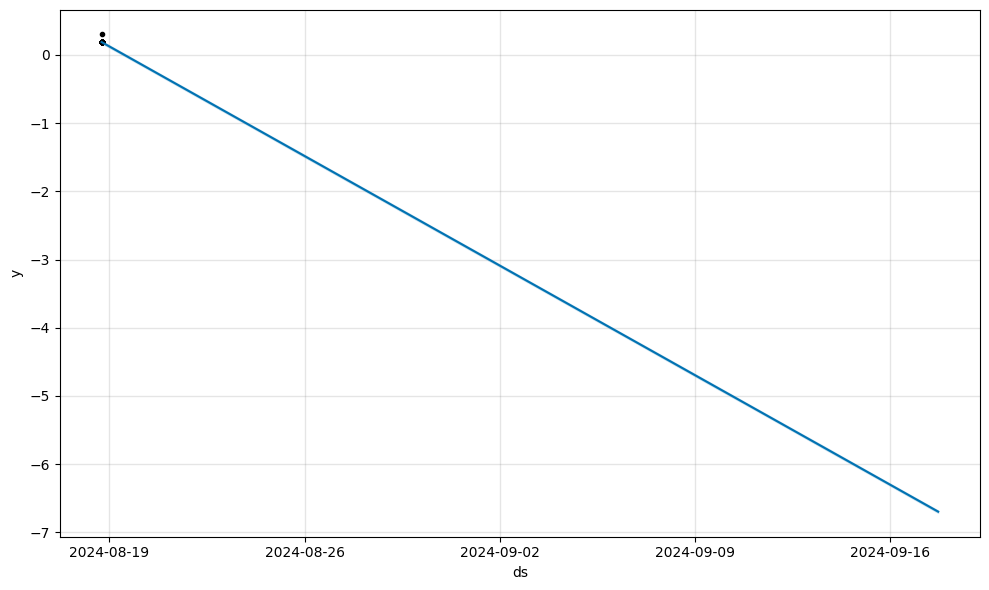

In [8]:
fig1 = m.plot(forecast)

/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


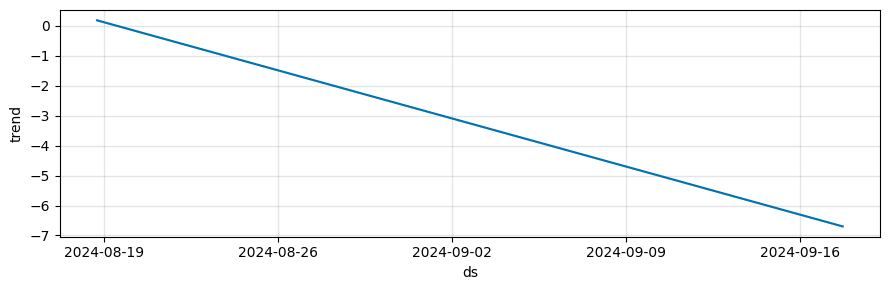

In [9]:
fig2 = m.plot_components(forecast)

In [10]:
forecast[["ds", "yhat"]].tail()

,ds,yhat
124,2024-09-13 17:24:58.139,-5.778414
125,2024-09-14 17:24:58.139,-6.007847
126,2024-09-15 17:24:58.139,-6.237279
127,2024-09-16 17:24:58.139,-6.466711
128,2024-09-17 17:24:58.139,-6.696144


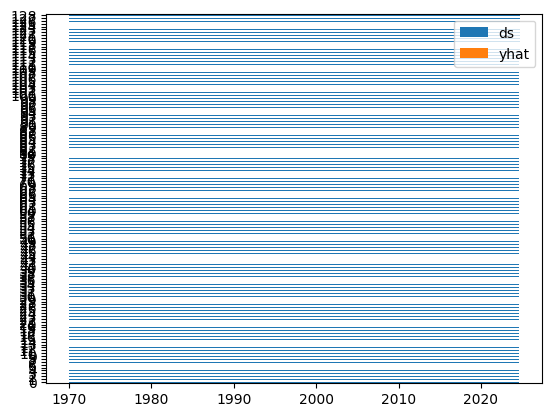

In [11]:
fig3 = forecast[["ds", "yhat"]].plot.barh()

In [12]:
forecast_dict = forecast[["ds", "yhat"]].to_dict()
pprint(forecast_dict)

{'ds': {0: Timestamp('2024-08-18 17:19:50.753000'),
        1: Timestamp('2024-08-18 17:20:24.901000'),
        2: Timestamp('2024-08-18 17:20:24.936000'),
        3: Timestamp('2024-08-18 17:20:24.993000'),
        4: Timestamp('2024-08-18 17:20:25.180000'),
        5: Timestamp('2024-08-18 17:20:25.305000'),
        6: Timestamp('2024-08-18 17:20:26.741000'),
        7: Timestamp('2024-08-18 17:20:26.838000'),
        8: Timestamp('2024-08-18 17:20:27.585000'),
        9: Timestamp('2024-08-18 17:20:27.707000'),
        10: Timestamp('2024-08-18 17:20:27.791000'),
        11: Timestamp('2024-08-18 17:20:27.855000'),
        12: Timestamp('2024-08-18 17:20:27.905000'),
        13: Timestamp('2024-08-18 17:20:27.956000'),
        14: Timestamp('2024-08-18 17:20:28.003000'),
        15: Timestamp('2024-08-18 17:20:28.129000'),
        16: Timestamp('2024-08-18 17:20:29.392000'),
        17: Timestamp('2024-08-18 17:20:29.470000'),
        18: Timestamp('2024-08-18 17:20:30.049000'),
   

In [13]:
new_data = {"x": [], "y": []}

ds = forecast_dict["ds"]
y = forecast_dict["yhat"]
for value in ds.values():
    new_data["x"].append(str(value))
for value in y.values():
    new_data["y"].append(value)

t_from = str(datetime.fromisoformat(new_data["x"][0]))
t_to = str(datetime.fromisoformat(new_data["x"][-1]))
new_data["t_from"] = t_from
new_data["t_to"] = t_to
new_data["created_at"] = datetime.now().isoformat()

pprint(new_data)

{'created_at': '2024-08-18T18:21:22.898438',
 't_from': '2024-08-18 17:19:50.753000',
 't_to': '2024-09-17 17:24:58.139000',
 'x': ['2024-08-18 17:19:50.753000',
       '2024-08-18 17:20:24.901000',
       '2024-08-18 17:20:24.936000',
       '2024-08-18 17:20:24.993000',
       '2024-08-18 17:20:25.180000',
       '2024-08-18 17:20:25.305000',
       '2024-08-18 17:20:26.741000',
       '2024-08-18 17:20:26.838000',
       '2024-08-18 17:20:27.585000',
       '2024-08-18 17:20:27.707000',
       '2024-08-18 17:20:27.791000',
       '2024-08-18 17:20:27.855000',
       '2024-08-18 17:20:27.905000',
       '2024-08-18 17:20:27.956000',
       '2024-08-18 17:20:28.003000',
       '2024-08-18 17:20:28.129000',
       '2024-08-18 17:20:29.392000',
       '2024-08-18 17:20:29.470000',
       '2024-08-18 17:20:30.049000',
       '2024-08-18 17:20:30.100000',
       '2024-08-18 17:20:30.421000',
       '2024-08-18 17:20:30.486000',
       '2024-08-18 17:20:30.491000',
       '2024-08-18 17:20

In [13]:
from dotenv import find_dotenv, dotenv_values
import pymongo

config = dotenv_values(find_dotenv())

try:
    atlas_uri = config.get("ATLAS_URI")
except:
    print("atlas uri not found")

db_name = "predict_test"
collection_name = "predictions"

mongo_client = pymongo.MongoClient(atlas_uri)

database = mongo_client[db_name]
collection = database[collection_name]

doc_count = collection.count_documents (filter = {})
print (f"Document count before delete : {doc_count:,}")

result = collection.delete_many(filter= {})
print (f"Deleted docs : {result.deleted_count}")

returned_id = collection.insert_one(new_data).inserted_id
print(returned_id)

ModuleNotFoundError: No module named 'dotenv'

In [18]:
mongo_df = pd.DataFrame({"time": new_data["x"], "predicted_transaction_amount": new_data["y"]})

In [19]:
mongo_df.tail()

,time,predicted_transaction_amount
124,2024-09-13 17:24:58.139000,-5.778414
125,2024-09-14 17:24:58.139000,-6.007847
126,2024-09-15 17:24:58.139000,-6.237279
127,2024-09-16 17:24:58.139000,-6.466711
128,2024-09-17 17:24:58.139000,-6.696144


<Axes: >

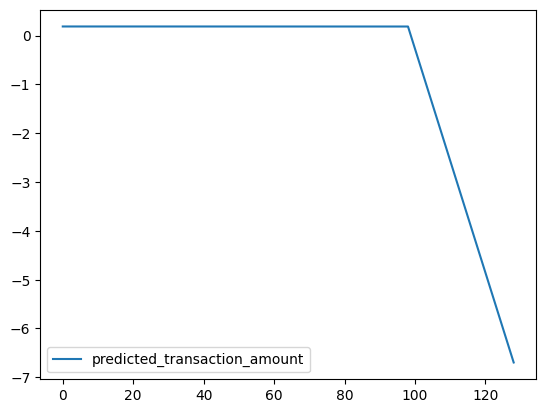

In [20]:
mongo_df.plot()